### Libraries

In [90]:
import pandas as pd
import numpy as np 
from gensim.models import Word2Vec
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

In [99]:
data_train = pd.read_csv('Data/data_train_preproc_all.csv')
data_test = pd.read_csv('Data/data_test_preproc_all.csv')
X_train = data_train['Review_Text']
X_test = data_test['Review_Text']
y_train = data_train['Sentiment']
y_test = data_test['Sentiment']

### Word2Vec (Continious Bag of Words) +GradientBoostingClassifier

In [100]:
tokenised_train = X_train.apply(lambda x: x.split())
v_size = 500

word2vec_gradient_boosting = Word2Vec(tokenised_train, vector_size=v_size,window=3, min_count=1, sg=1)

In [101]:
def get_vector_average(text):
    vector = np.zeros(v_size)
    # in order to normalise by the number of words in the text
    count = 0
    for word in text:
        try:
            vector += word2vec_gradient_boosting.wv[word]
            count += 1
        except KeyError:
            pass
    return vector / count

X_train = X_train.apply(lambda x: get_vector_average(x.split()))
X_test = X_test.apply(lambda x: get_vector_average(x.split()))


In [102]:
gb = GradientBoostingClassifier()

param_dist = {'n_estimators': randint(200, 1000),
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': randint(1, 100),
              'min_samples_split': randint(2, 20),
              'min_samples_leaf': randint(1, 20),
}

rs_gb = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1, verbose=1, random_state=42)

In [103]:
gb = GradientBoostingClassifier()
gb.fit(list(X_train), y_train)

GradientBoostingClassifier()

In [104]:
# best_gb_word2vec_skip_gram = rs_gb.best_estimator_
# best_gb_word2vec_skip_gram.fit(list(X_train), y_train)
predictions = gb.predict(list(X_test))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
print(cm_df)

          Negative  Neutral  Positive
Negative       336       82       307
Neutral        151      151       720
Positive        57       83      6645


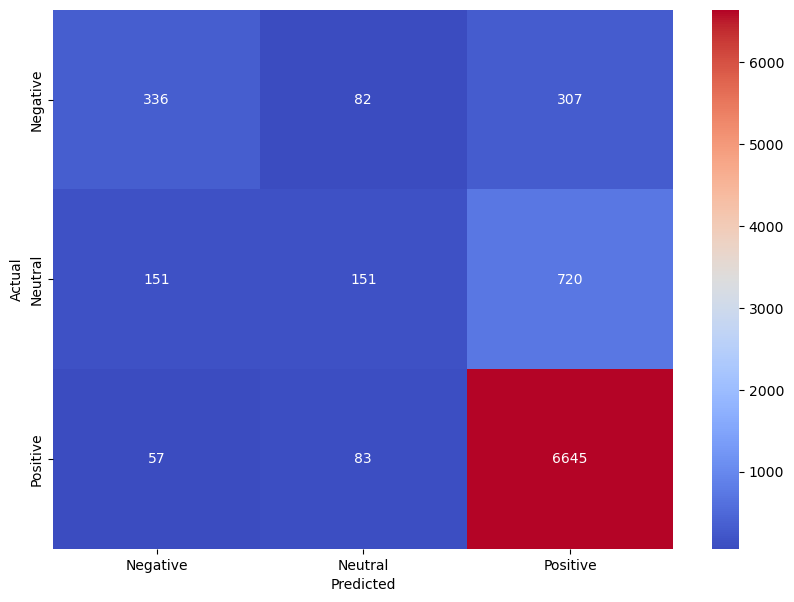

In [105]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='coolwarm', fmt='g')    
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [106]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.62      0.46      0.53       725
           0       0.48      0.15      0.23      1022
           1       0.87      0.98      0.92      6785

    accuracy                           0.84      8532
   macro avg       0.65      0.53      0.56      8532
weighted avg       0.80      0.84      0.80      8532

